### Import libraries and data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon
import os
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import pyproj
from shapely.ops import transform
from functools import partial


parent_directory = os.path.dirname(os.getcwd())
bike_file_path = parent_directory + '/data/Existing_Bike_Network_2023.geojson'

bike_lanes = gpd.read_file(bike_file_path)
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')

blocks_file_path = parent_directory + '/data/census2020_blockgroups.json' #https://data.boston.gov/dataset/census-2020-block-groups
blocks = gpd.read_file(blocks_file_path)

In [2]:
tracts_2020_file_path = parent_directory + '/data/2020_Census_Tracts_in_Boston.geojson' #https://data.boston.gov/dataset/2020-census-tracts-in-boston
tracts_2020 = gpd.read_file(tracts_2020_file_path)
tracts_2010_file_path = parent_directory + '/data/Census_2010_Tracts.geojson' #https://data.boston.gov/dataset/census-2010-tracts
tracts_2010 = gpd.read_file(tracts_2010_file_path)
tract_dict = pd.read_csv("https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_st25.txt", sep= '|') # tract translation between 2010&2020

#### merging tracts - if needed

In [3]:
tract_dict

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART
0,20790203629183,25001010100,Census Tract 101,25046216,12765872,G5020,S,20740203629183,25001010100,Census Tract 101,25046216,12765872,G5020,S,25046216,12765872
1,207903716665007,25001010206,Census Tract 102.06,51240800,18828934,G5020,S,207403716665007,25001010206,Census Tract 102.06,51240800,18830100,G5020,S,51240800,18828934
2,207903716665091,25001010208,Census Tract 102.08,54268861,11461462,G5020,S,207403716665091,25001010208,Census Tract 102.08,54268861,11461462,G5020,S,54268861,11461462
3,207903716665297,25001010304,Census Tract 103.04,18347856,7830614,G5020,S,207403716665297,25001010304,Census Tract 103.04,18345149,7830614,G5020,S,18344716,7830614
4,207903716665297,25001010304,Census Tract 103.04,18347856,7830614,G5020,S,207403716665051,25001010306,Census Tract 103.06,17828269,1730719,G5020,S,243,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,2079015614076010,25027761401,Census Tract 7614.01,42913109,1640567,G5020,S,20740260104949,25017388100,Census Tract 3881,26638827,317226,G5020,S,1465,0
2438,2079015614076010,25027761401,Census Tract 7614.01,42913109,1640567,G5020,S,20740515417565,25027713100,Census Tract 7131,71144125,1335617,G5020,S,160,0
2439,2079015614076010,25027761401,Census Tract 7614.01,42913109,1640567,G5020,S,207403709722980,25027761400,Census Tract 7614,68479061,1850317,G5020,S,42911484,1640567
2440,2079015614077051,25027761402,Census Tract 7614.02,25568096,209089,G5020,S,20740260105924,25017325100,Census Tract 3251,24702986,1437476,G5020,S,519,0


In [86]:
tracts_2010.columns

Index(['FID', 'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10',
       'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_STAr', 'Shape_STLe', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')

In [85]:
tracts_2020.columns

Index(['geoid20', 'countyfp20', 'namelsad20', 'statefp20', 'tractce20',
       'intptlat20', 'name20', 'funcstat20', 'intptlon20', 'mtfcc20',
       'aland20', 'awater20', 'objectid', 'geometry'],
      dtype='object')

In [91]:
# merging tract data
final_tracts = tracts_2010.copy()
final_tracts.rename(columns = {'geometry': 'geometry10'}, inplace=True)
final_tracts['geo_id20'] = None
final_tracts['name20'] = None
final_tracts['geometry20'] = None
for i, row in tracts_2010.iterrows():
    geo_id10 = int(row['GEOID10'])
    match = tract_dict.loc[tract_dict['GEOID_TRACT_10']==geo_id10]
    if len(match)!=1:
        continue
    elif len(match)==1:
        geo_id20 = match['GEOID_TRACT_20'].iloc[0]
        name20 = tracts_2020.loc[tracts_2020['geoid20']==str(geo_id20)]['name20'].iloc[0]
        geometry20 = tracts_2020.loc[tracts_2020['geoid20']==str(geo_id20)]['geometry'].iloc[0]
        final_tracts.at[i, 'geo_id20'] = geo_id20
        final_tracts.at[i, 'name20'] = name20
        final_tracts.at[i, 'geometry20'] = geometry20
final_tracts

,FID,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,...,INTPTLAT10,INTPTLON10,Shape_STAr,Shape_STLe,Shape__Area,Shape__Length,geometry10,geo_id20,name20,geometry20
0,1,1,25,025,010405,25025010405,104.05,Census Tract 104.05,G5020,S,...,+42.3398654,-071.0896052,3.914568e+06,14629.550361,6.660999e+05,6036.192858,"POLYGON ((-71.09009 42.34667, -71.09001 42.346...",25025010405,104.05,POLYGON ((-71.0957456013691 42.337735667773735...
1,2,2,25,025,010404,25025010404,104.04,Census Tract 104.04,G5020,S,...,+42.3419667,-071.0886375,1.472714e+06,5277.643216,2.506124e+05,2176.592125,"POLYGON ((-71.09066 42.33977, -71.09103 42.339...",25025010404,104.04,"POLYGON ((-71.091810600965 42.33987966811, -71..."
2,3,3,25,025,010801,25025010801,108.01,Census Tract 108.01,G5020,S,...,+42.3541193,-071.0770216,1.376667e+06,6166.497167,2.343579e+05,2542.042976,"POLYGON ((-71.08160 42.35371, -71.08044 42.354...",25025010801,108.01,POLYGON ((-71.08159559758384 42.35371267163521...
3,4,4,25,025,010702,25025010702,107.02,Census Tract 107.02,G5020,S,...,+42.3518354,-071.0755159,3.228780e+06,7818.852369,5.496140e+05,3224.572988,"POLYGON ((-71.07066 42.35186, -71.07046 42.351...",25025010702,107.02,"POLYGON ((-71.08086259755855 42.3522756709338,..."
4,5,5,25,025,010204,25025010204,102.04,Census Tract 102.04,G5020,S,...,+42.3462887,-071.1033879,2.741497e+06,7621.654206,4.665852e+05,3143.610963,"POLYGON ((-71.10683 42.34876, -71.10520 42.348...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,177,177,25,025,020301,25025020301,203.01,Census Tract 203.01,G5020,S,...,+42.3631745,-071.0686463,2.761716e+06,10710.510922,4.702803e+05,4418.758815,"POLYGON ((-71.06516 42.36419, -71.06522 42.363...",25025020301,203.01,POLYGON ((-71.07235059482979 42.36135267326971...
177,178,178,25,025,020101,25025020101,201.01,Census Tract 201.01,G5020,S,...,+42.3577086,-071.0694112,2.401693e+06,7637.223404,4.088999e+05,3149.451618,"POLYGON ((-71.07257 42.35777, -71.07234 42.358...",None,None,None
178,179,179,25,025,081001,25025081001,810.01,Census Tract 810.01,G5020,S,...,+42.3345666,-071.1068303,6.011082e+06,16640.520998,1.022671e+06,6862.328681,"POLYGON ((-71.10486 42.33405, -71.10488 42.333...",25025081001,810.01,POLYGON ((-71.11296960730827 42.33217466617044...
179,180,180,25,025,010403,25025010403,104.03,Census Tract 104.03,G5020,S,...,+42.3450750,-071.0880610,9.531475e+05,4227.644208,1.622134e+05,1744.671475,"POLYGON ((-71.08985 42.34435, -71.08977 42.344...",25025010403,104.03,"POLYGON ((-71.0898505999969 42.34435166898183,..."


In [121]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming you have 'tracts_2010' and 'tracts_2020' GeoDataFrames loaded with appropriate columns

overlap_percentages = []

# Iterate over polygons in 2010
for idx_2010, row_2010 in tracts_2010.iterrows():
    polygon_2010 = row_2010['geometry']
    max_overlap_area = 0
    total_area_2010 = polygon_2010.area

    # Iterate over polygons in 2020 to find the best match
    for idx_2020, row_2020 in tracts_2020.iterrows():
        polygon_2020 = row_2020['geometry']

        # Calculate the overlap area between the two polygons
        overlap_area = polygon_2010.intersection(polygon_2020).area

        if overlap_area > max_overlap_area:
            max_overlap_area = overlap_area

    # Store the matching results in the DataFrame
    # Calculate overlap percentage and store the result
    overlap_percentage = (max_overlap_area / total_area_2010) * 100
    overlap_result = {
        'geo_id10': row_2010['GEOID10'],
        'overlap_percentage': overlap_percentage
    }
    overlap_percentages.append(overlap_result)

# Create a DataFrame from the overlap percentages
overlap_df = pd.DataFrame(overlap_percentages)

# Print or return the DataFrame
print(overlap_df)


        geo_id10  overlap_percentage
0    25025010405           99.627046
1    25025010404           99.806329
2    25025010801           99.665235
3    25025010702           99.949551
4    25025010204           99.391132
..           ...                 ...
176  25025020301           97.816664
177  25025020101           97.907169
178  25025081001           99.997225
179  25025010403           99.996244
180  25025000100           59.461757

[181 rows x 2 columns]


In [122]:
overlap_df

,geo_id10,overlap_percentage
0,25025010405,99.627046
1,25025010404,99.806329
2,25025010801,99.665235
3,25025010702,99.949551
4,25025010204,99.391132
...,...,...
176,25025020301,97.816664
177,25025020101,97.907169
178,25025081001,99.997225
179,25025010403,99.996244


#### format polygons + group into tracts

In [52]:
# convert block polygons to LatLong 

# Define the UTM projection for Zone 19T (for Boston, MA)
state_plane = pyproj.Proj(init='epsg:2249', preserve_units=True)

# Define a function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(x, y):
    lon, lat = state_plane(x, y, inverse=True)
    return lon, lat

# Define a function to transform coordinates to UTM and then to latitude and longitude
def transform_to_latlon(geom):
    transformed_geom = transform(partial(pyproj.transform, state_plane, pyproj.Proj(init='epsg:4326')), geom)
    return transformed_geom

for i, row in blocks.iterrows():
    poly = row['geometry']
    # Check if the geometry is a MultiPolygon
    if poly.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through individual polygons
        polygon_latlon = []
        for single_poly in poly.geoms:
            for ring in single_poly.exterior.coords:
                lat, lon = utm_to_latlon(ring[0], ring[1])
                polygon_latlon.append((lat, lon))
        formatted_polygon = MultiPolygon([Polygon(polygon_latlon)])
    else:
        polygon_latlon = []
        for ring in poly.exterior.coords:
            lat, lon = utm_to_latlon(ring[0], ring[1])
            polygon_latlon.append((lat, lon))
        formatted_polygon = Polygon(polygon_latlon)
    
    blocks.at[i, 'formatted_polygon'] = formatted_polygon

c:\Users\Raviv\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


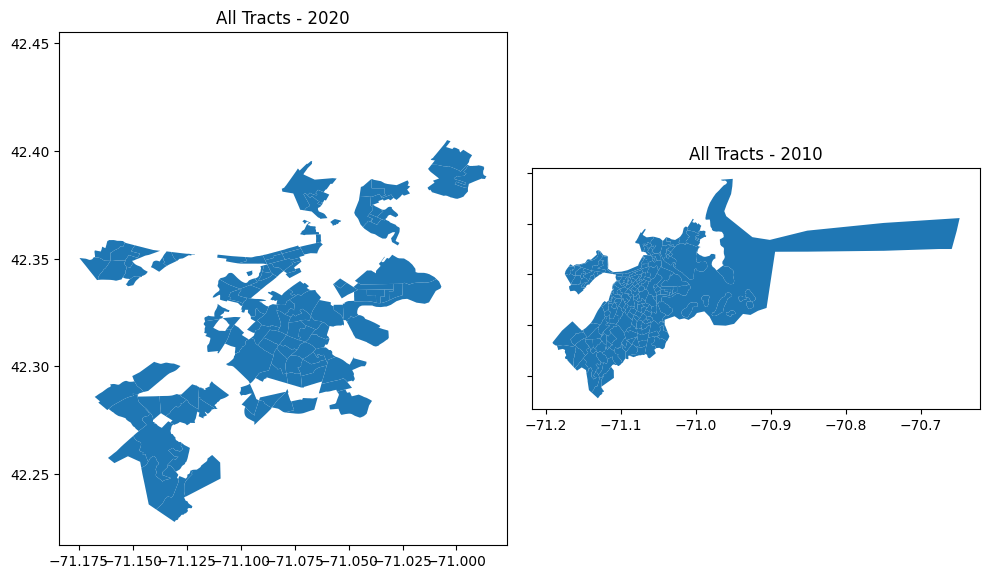

In [92]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Create subplots with equal aspect ratio
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
# Convert final_tracts to GeoDataFrames
tracts2020_gdf = gpd.GeoDataFrame(final_tracts, geometry='geometry20')
tracts2010_gdf = gpd.GeoDataFrame(final_tracts, geometry='geometry10')

# Plot the polygons
tracts2020_gdf.plot(ax=ax[0])
ax[0].set_title('All Tracts - 2020')
tracts2010_gdf.plot(ax=ax[1])
ax[1].set_title('All Tracts - 2010')

plt.tight_layout()
plt.show()


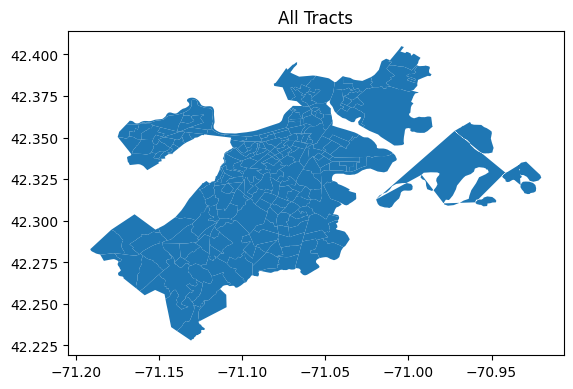

In [105]:
from shapely.ops import unary_union
grouped_tracts = blocks.groupby('TRACTCE20')['formatted_polygon'].apply(unary_union).reset_index()
tracts_gdf = gpd.GeoDataFrame(tracts_2020, geometry='formatted_polygon')

# Plot the polygons
tracts_gdf.plot()
plt.title('All Tracts')
plt.show()

In [255]:
# define circle for each tract: centroid point + defined radius
import math

RADIUS = 1 # in km

def km_to_degrees(km, latitude):
    # Radius of the Earth in meters
    earth_radius = 6378137.0
    # Calculate the circumference of the Earth at given latitude
    circumference = 2 * math.pi * earth_radius * math.cos(math.radians(latitude))
    # Convert meters to degrees of longitude
    degrees_per_meter = 360.0 / circumference
    degrees = km *1000 * degrees_per_meter
    return degrees

for i, row in grouped_tracts.iterrows():
    # Find the center point (centroid) of the combined polygon
    center_point = row['formatted_polygon'].centroid
    lat = center_point.y
    # Define radius of the circle
    radius_km = RADIUS  # Change this value to set the radius of the circle
    radius_deg = km_to_degrees(radius_km, lat)
    # Create a circle around the center point with the specified radius
    circle = Point(center_point).buffer(radius_deg)
    grouped_tracts.at[i, 'circle'] = circle

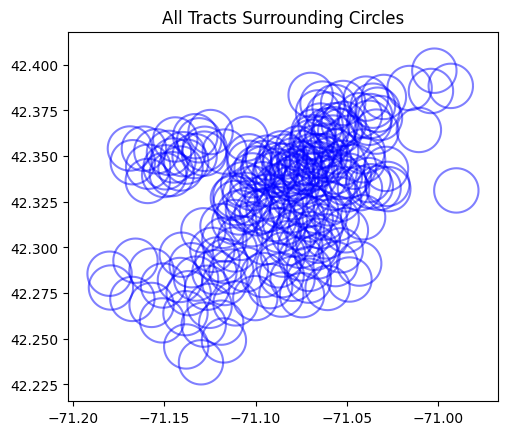

In [256]:
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='circle')

# Plot the polygons
tracts_gdf.plot(facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.5)
plt.title('All Tracts Surrounding Circles')
plt.show()

In [94]:
tracts2010_gdf.columns

Index(['FID', 'OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10',
       'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_STAr', 'Shape_STLe', 'Shape__Area',
       'Shape__Length', 'geometry10', 'geo_id20', 'name20', 'geometry20',
       'buffered_geometry'],
      dtype='object')

#### tracts 2010 - adding buffers + merging with bike lane data

In [6]:
tracts2010_gdf = gpd.GeoDataFrame(tracts_2010, geometry='geometry')

C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\122560025.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(tracts2010_gdf.geometry.centroid.x, tracts2010_gdf.geometry.centroid.y, tracts2010_gdf['NAME10']):


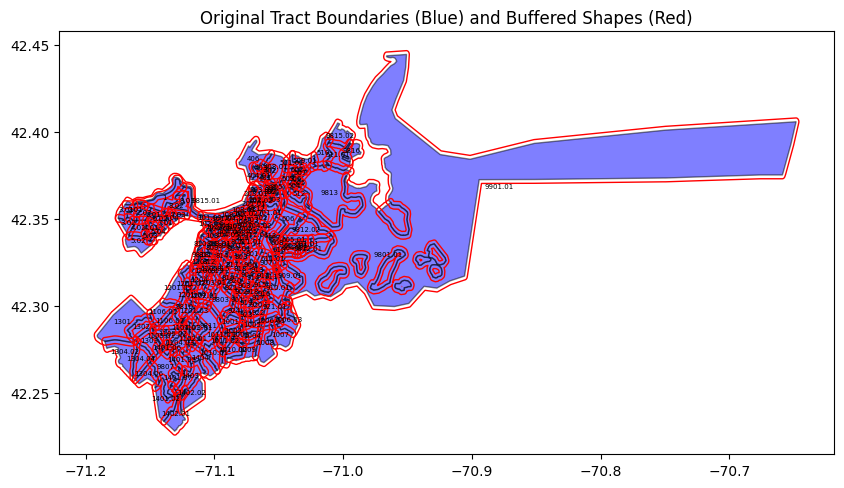

In [8]:
import geopandas as gpd
from shapely.geometry import Polygon

# Function to create a shape with a minimum distance from the polygon
def create_buffer_shape(polygon, buffer_distance):
    buffered_polygon = polygon.buffer(buffer_distance)
    return buffered_polygon

# Buffer distance in feet (800 ft)
buffer_distance_feet = 800
feet_per_degree = 364000  # approximate value for latitude

# Convert buffer distance from feet to degrees
buffer_distance_degrees = buffer_distance_feet / feet_per_degree

# Create a new column in the GeoDataFrame to store the buffered shapes
tracts2010_gdf['buffered_geometry'] = tracts2010_gdf['geometry'].apply(lambda x: create_buffer_shape(x, buffer_distance_degrees))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot original polygons in blue
tracts2010_gdf.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black', legend=True)

# Plot buffered polygons in red
tracts2010_gdf.set_geometry('buffered_geometry').plot(ax=ax, facecolor='none', edgecolor='red')

# Add labels to the centers of the polygons
for x, y, label in zip(tracts2010_gdf.geometry.centroid.x, tracts2010_gdf.geometry.centroid.y, tracts2010_gdf['NAME10']):
    ax.text(x, y, label, fontsize=5, ha='center')
ax.set_title('Original Tract Boundaries (Blue) and Buffered Shapes (Red)')
plt.show()


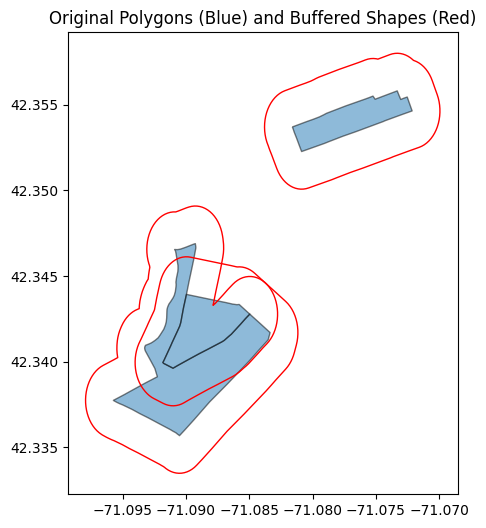

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
tracts2010_gdf[:3].plot(ax=ax, alpha=0.5,edgecolor='black', legend=True)
tracts2010_gdf[:3].set_geometry('buffered_geometry').plot(ax=ax, facecolor='none', edgecolor='red')

ax.set_title('Original Polygons (Blue) and Buffered Shapes (Red)')
plt.show()

In [ ]:
#define bike lane dictionary
infra_dict = {'BFBL' : 'Buffered bike lane',
'BL' : 'Bike lane',
'BLSL' : 'Bike lane on one side, shared lane on the opposite side',
'BSBL' : 'Bus/bike lane',
'CFBL' : 'Contra-flow bike street',
'NSUP' : 'Shared use path, natural surface',
'NW' : 'Neighborway, marked',
'NW-U' : 'Neighborway, unmarked',
'SBL' : 'Separated bike lane',
'SBLBL' : 'Separated bike lane on one side, bike lane on the opposite side',
'SLM' : 'Shared lane markings',
'SLMTC' : 'Shared lane markings, Traffic calmed street',
'SRd' : 'Shared road',
'SUB' : 'Shared use path bridge',
'SUC' : 'Shared use connector',
'SUP' : 'Shared use path',
'TC' : 'Traffic calmed street',
}
bike_lanes['ExisFacil'].replace(infra_dict, inplace=True) # remove later

### Gathering Tabular Data by Neighborhood 

##### Dorchester

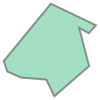

In [9]:
# polygon of coords, from google maps
pol = [(42.29206533274252, -71.09562722715653), (42.33090986566151, -71.06369820984568), (42.316314241773526, -71.03314248394966), (42.31085587795951, -71.03794900269062), (42.314537152039506, -71.04447213526767),
(42.28863672310401, -71.03777734130702), (42.268188176048305, -71.06129495080786), (42.27949285134003, -71.06678811508326), (42.28088991760289, -71.0841259148275), (42.28495393424176, -71.09322396815864), (42.29206533274252, -71.09562722715653)]
dorchester_coords = [(y,x) for (x,y) in pol]

dorchester_poly = Polygon(dorchester_coords)
dorchester_bike = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]

Polygon(dorchester_coords)

In [10]:
dorchester_tracts = tracts2010_gdf[tracts2010_gdf['geometry'].apply(lambda polygon: polygon.intersects(dorchester_poly))]
print(dorchester_tracts.shape)
dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True)
print(dorchester_tracts.shape)

(42, 20)
(41, 20)


C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\1317228161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True)


C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\3619270258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True)
C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\3619270258.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(dorch_poly.geometry.centroid.x, dorch_poly.geometry.centroid.y, dorch_poly['NAME10']):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\3619270258.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-c

Text(0.5, 1.0, '2010 Tracts + Buffers: Dorchester')

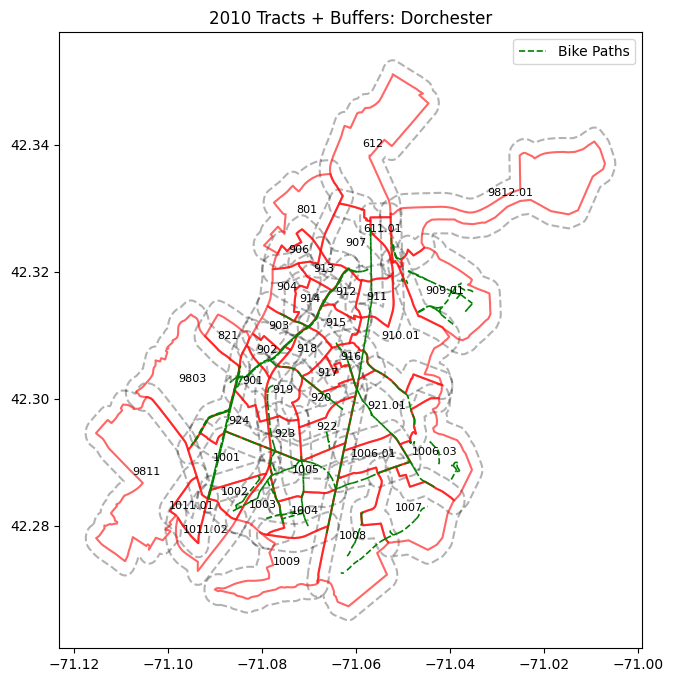

In [11]:
dorchester_tracts = tracts2010_gdf[tracts2010_gdf['geometry'].apply(lambda polygon: polygon.intersects(dorchester_poly))] # get tracts that intersect with dorchester polygon
dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True) # dropping the weird tract
# Create a new figure and axis
fig, ax = plt.subplots(figsize = (16,8))
dorch_buffer = gpd.GeoDataFrame(dorchester_tracts, geometry='buffered_geometry')
dorch_buffer['buffered_geometry'].plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

dorch_poly = gpd.GeoDataFrame(dorchester_tracts, geometry='geometry')
dorch_poly['geometry'].plot(ax=ax, color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
# Add labels to the centers of the polygons
for x, y, label in zip(dorch_poly.geometry.centroid.x, dorch_poly.geometry.centroid.y, dorch_poly['NAME10']):
    ax.text(x, y, label, fontsize=8, ha='center')
dorch_bike_lanes = gpd.GeoDataFrame(dorchester_bike, geometry='geometry')
dorch_bike_lanes['geometry'].plot(ax=ax, color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax.legend()
plt.title('2010 Tracts + Buffers: Dorchester')

C:\Users\Raviv\AppData\Local\Temp\ipykernel_6652\66752681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True)
C:\Users\Raviv\AppData\Local\Temp\ipykernel_6652\66752681.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(dorch_2010.geometry.centroid.x, dorch_2010.geometry.centroid.y, dorch_2010['NAME10']):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_6652\66752681.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-

Text(0.5, 1.0, '2010 vs 2020 Tracts: Dorchester')

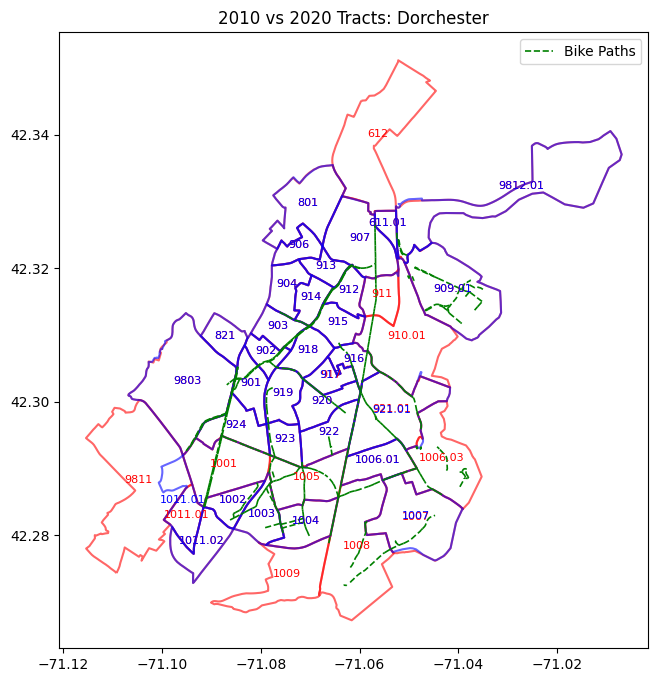

In [118]:
# comparing 2010 and 2020 tracts

dorchester_tracts = final_tracts[final_tracts['geometry10'].apply(lambda polygon: polygon.intersects(dorchester_poly))]
dorchester_tracts.drop(dorchester_tracts[dorchester_tracts['NAME10']=='9901.01'].index, inplace=True)
# Create a new figure and axis
fig, ax = plt.subplots(figsize = (16,8))
# dorch_buffer = gpd.GeoDataFrame(dorchester_tracts, geometry='buffered_geometry')
# dorch_buffer['buffered_geometry'].plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

dorch_2010 = gpd.GeoDataFrame(dorchester_tracts, geometry='geometry10')
dorch_2010['geometry10'].plot(ax=ax, color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders 2010")
# Add labels to the centers of the polygons
for x, y, label in zip(dorch_2010.geometry.centroid.x, dorch_2010.geometry.centroid.y, dorch_2010['NAME10']):
    ax.text(x, y, label, fontsize=8, color = 'r', ha='center')

dorch_2020 = gpd.GeoDataFrame(dorchester_tracts, geometry='geometry20')
dorch_2020['geometry20'].plot(ax=ax, color='none', edgecolor='b',  linewidth=1.5, alpha=0.6, label = "Tract Borders 2020")
for x, y, label in zip(dorch_2020.geometry.centroid.x, dorch_2020.geometry.centroid.y, dorch_2020['name20']):
    ax.text(x, y, label, fontsize=8, color = 'b', ha='center')

dorch_bike_lanes = gpd.GeoDataFrame(dorchester_bike, geometry='geometry')
dorch_bike_lanes['geometry'].plot(ax=ax, color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax.legend()
plt.title('2010 vs 2020 Tracts: Dorchester')

In [20]:
# create a long-format df of all bike lanes in Dorchester, by tract
joined_dorch = gpd.sjoin(dorchester_tracts, dorch_bike_lanes, how='left', op='intersects')

grouped_dorch = joined_dorch.groupby(['NAME10', 'year','ExisFacil']).agg({
    'Shape_Leng': 'sum',
}).reset_index()

dorch_pivot = pd.pivot_table(grouped_dorch, index=['NAME10', 'year'], columns='ExisFacil', values='Shape_Leng', aggfunc='sum', fill_value=0).reset_index()
dorch_pivot['total_built'] = dorch_pivot[['BFBL', 'BL', 'BLSL', 'SBL', 'SLM', 'SUP']].sum(axis=1)
dorch_pivot.rename(columns={'ExisFacil':'index','NAME10':'tract'},inplace=True)
dorch_pivot.sort_values(by=['tract', 'year'], inplace=True) #sorting by year to sum cummulatively
# add a column to show total built in past 5 years
dorch_pivot['cumulative_length'] = dorch_pivot.groupby('tract')['total_built'].cumsum(axis=0)
dorch_pivot

C:\Users\Raviv\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ExisFacil,tract,year,BFBL,BL,BLSL,SBL,SLM,SLMTC,SUP,total_built,cumulative_length
0,1001,2010,0.000000,1968.438556,0.0,0.000000,444.178997,0.0,0.0,2412.617554,2412.617554
1,1001,2012,0.000000,480.726141,0.0,0.000000,370.338131,0.0,0.0,851.064272,3263.681826
2,1001,2015,0.000000,0.000000,0.0,0.000000,61.996534,0.0,0.0,61.996534,3325.678360
3,1001,2020,0.000000,0.000000,0.0,173.850878,0.000000,0.0,0.0,173.850878,3499.529238
4,1002,2010,0.000000,223.011427,0.0,0.000000,86.715593,0.0,0.0,309.727020,309.727020
...,...,...,...,...,...,...,...,...,...,...,...
82,9803,2009,0.000000,202.660149,0.0,0.000000,0.000000,0.0,0.0,202.660149,721.809259
83,9803,2010,0.000000,0.000000,0.0,0.000000,128.249559,0.0,0.0,128.249559,850.058818
84,9803,2012,0.000000,0.000000,0.0,0.000000,799.222219,0.0,0.0,799.222219,1649.281036
85,9803,2020,0.000000,0.000000,0.0,1327.766788,0.000000,0.0,0.0,1327.766788,2977.047824


#### plots

In [1]:
import matplotlib.pyplot as plt
dorch_pivot_sorted = dorch_pivot.sort_values(by=['TRACTCE20', 'year']) #sorting by year to sum cummulatively

dorch_pivot_sorted['cumulative_length'] = dorch_pivot_sorted.groupby('TRACTCE20')['total_built'].cumsum(axis=0)

# Assuming dorch_pivot contains the data with columns 'polygon_id', 'year', and total lengths of bike lanes
unique_polygon_ids = dorch_pivot_sorted['TRACTCE20'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_polygon_ids)))

# Iterate through unique polygon IDs and plot a line for each polygon
for i, polygon_id in enumerate(dorch_pivot_sorted['TRACTCE20'].unique()):
    polygon_data = dorch_pivot_sorted[dorch_pivot_sorted['TRACTCE20'] == polygon_id]
    plt.plot(polygon_data['year'], polygon_data['cumulative_length'], label=f'Polygon ID {polygon_id}', color=colors[i])

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Length of Bike Lanes')
plt.title('Change in Total Length of Bike Lanes By Tract - Dorchester')
# plt.legend(loc='best')  # Display legend for the lines
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


NameError: name 'dorch_pivot' is not defined

In [269]:
# Streets with most bike lanes
street_df = dorchester_bike.loc[dorchester_bike['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Columbia Road',
 'Dorchester Avenue',
 'Blue Hill Avenue',
 'Adams Street',
 'Talbot Avenue']

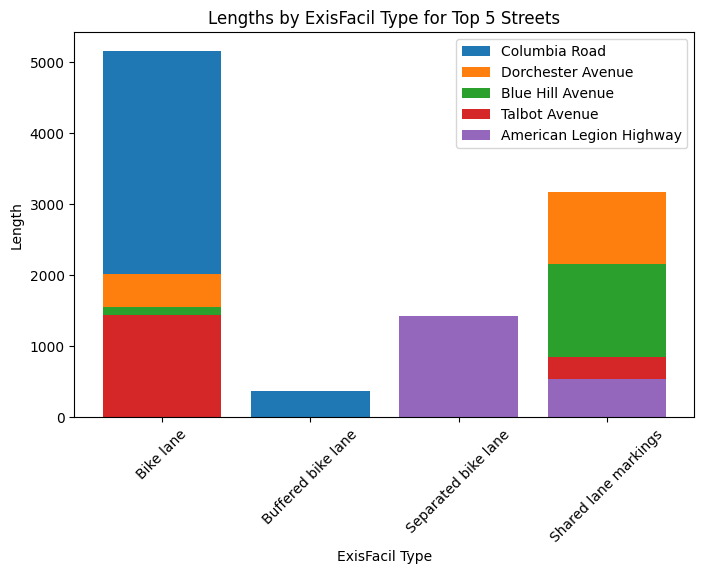

In [9]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


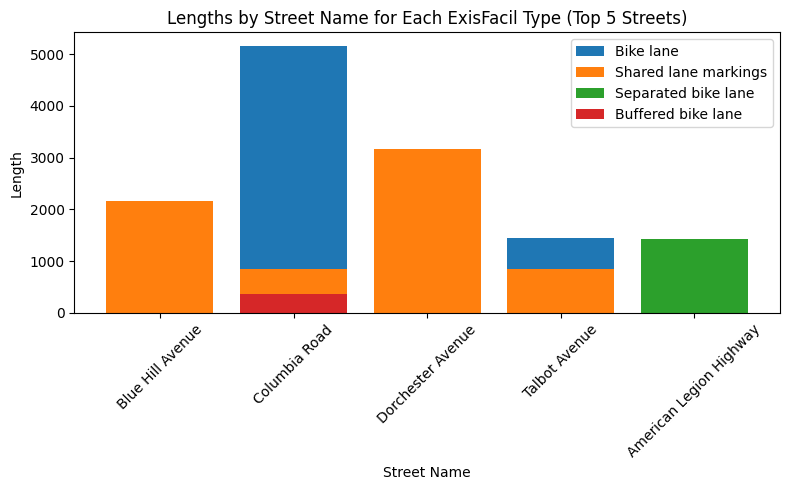

In [10]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

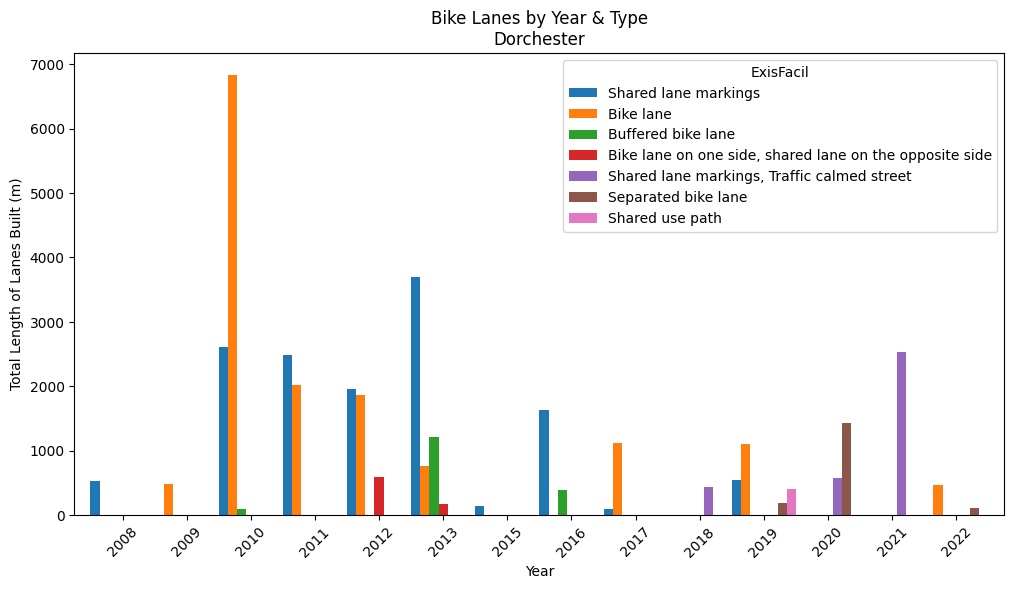

In [11]:
# total m of lanes by year and type
yealy_new_lanes = dorchester_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
fig, ax = plt.subplots(figsize=(12, 6))
yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
ax.set_xlabel('Year')
ax.set_ylabel('Total Length of Lanes Built (m)')
ax.set_title('Bike Lanes by Year & Type\nDorchester')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Roxbury

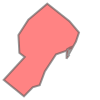

In [21]:
# polygon of coords, from google maps
rox_pol = [ (42.341608986056364, -71.08347172986149), (42.332253161966605, -71.07163155541365), (42.32621640774964, -71.06652803194476), (42.32138658725103, -71.0681611594548), (42.312258378390375, -71.07328003461689), (42.31782332073722, -71.07194482240432), (42.317195045437295, -71.07303726876006), (42.31890034951496, -71.06969923822862), 
       (42.31777709985751, -71.07181554914962), (42.31708331734832, -71.07300643204704), (42.31377440323021, -71.07315078148915), (42.31369434663409, -71.0721764227563), (42.31225331169338, -71.07325904357214), (42.31746430704819, -71.07048822726333), (42.3145482776965, -71.07881649709346),
       (42.30547247542557, -71.08476560337425), (42.29823831376148, -71.08747275766547), (42.298224610072566, -71.08712011436275), (42.297016652611624, -71.09120293313788), (42.292184591055154, -71.09589817472924), (42.300942429638944, -71.10671764448331),
       (42.313171166004146, -71.09548989285175), (42.315360010547955, -71.09834786558292), (42.324869276831514, -71.0988582179298), (42.33309438760423, -71.0935505536844), (42.341608986056364, -71.08347172986149)]

roxbury_coords = [(y,x) for (x,y) in rox_pol]
Polygon(roxbury_coords)

In [23]:
# Define the coordinates of the polygon (clockwise or counterclockwise order)
# Repeat the first point to close the polygon
# coords are written (long, lat), reversed from map data

# Create a Polygon object from the coordinates
roxbury_poly = Polygon(roxbury_coords)
roxbury_bike = bike_lanes[bike_lanes.geometry.within(roxbury_poly)]

In [308]:
roxbury_bike.head(1)

,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,year
90,91,Jewish War Veterans Drive,5190500,5,2,0,2009,BL,577.676677,577.676677,"LINESTRING (-71.09388 42.30524, -71.09376 42.3...",2009


C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\2577908587.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(rox_poly.geometry.centroid.x, rox_poly.geometry.centroid.y, rox_poly['NAME10']):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_3872\2577908587.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


Text(0.5, 1.0, '2010 Tracts + Buffers: Roxbury')

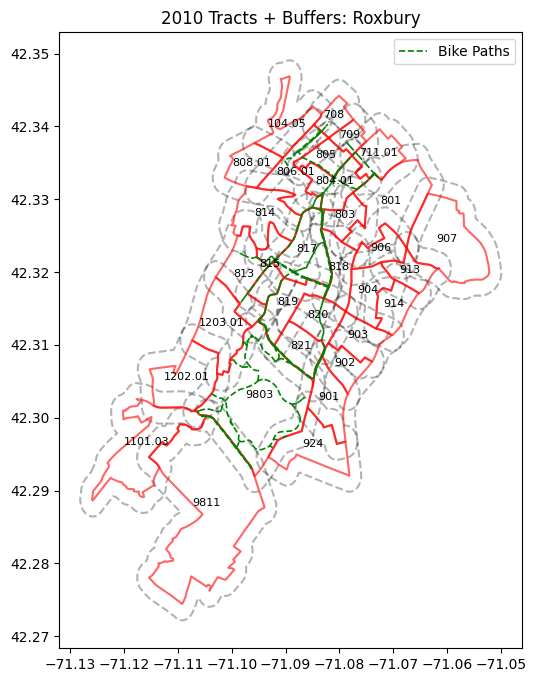

In [24]:
roxbury_tracts = tracts2010_gdf[tracts2010_gdf['geometry'].apply(lambda polygon: polygon.intersects(roxbury_poly))] # get tracts that intersect with roxbury polygon
# # Create a new figure and axis
fig, ax = plt.subplots(figsize = (16,8))
rox_buffer = gpd.GeoDataFrame(roxbury_tracts, geometry='buffered_geometry')
rox_buffer['buffered_geometry'].plot(ax=ax, color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

rox_poly = gpd.GeoDataFrame(roxbury_tracts, geometry='geometry')
rox_poly['geometry'].plot(ax=ax, color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
# Add labels to the centers of the polygons
for x, y, label in zip(rox_poly.geometry.centroid.x, rox_poly.geometry.centroid.y, rox_poly['NAME10']):
    ax.text(x, y, label, fontsize=8, ha='center')
rox_bike_lanes = gpd.GeoDataFrame(roxbury_bike, geometry='geometry')
rox_bike_lanes['geometry'].plot(ax=ax, color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax.legend()
plt.title('2010 Tracts + Buffers: Roxbury')

In [27]:
# create a long-format df of all bike lanes in Dorchester, by tract
joined_rox = gpd.sjoin(roxbury_tracts, rox_bike_lanes, how='left', op='intersects')

grouped_rox = joined_rox.groupby(['NAME10', 'year','ExisFacil']).agg({
    'Shape_Leng': 'sum',
}).reset_index()

rox_pivot = pd.pivot_table(grouped_rox, index=['NAME10', 'year'], columns='ExisFacil', values='Shape_Leng', aggfunc='sum', fill_value=0).reset_index()
rox_pivot['total_built'] = rox_pivot[['BFBL', 'BL', 'BLSL', 'SBL', 'SLM', 'SUP']].sum(axis=1)
rox_pivot.rename(columns={'ExisFacil':'index','NAME10':'tract'},inplace=True)
rox_pivot.sort_values(by=['tract', 'year'], inplace=True) #sorting by year to sum cummulatively
# add a column to show total built in past 5 years
rox_pivot['cumulative_length'] = rox_pivot.groupby('tract')['total_built'].cumsum(axis=0)

C:\Users\Raviv\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


##### plots

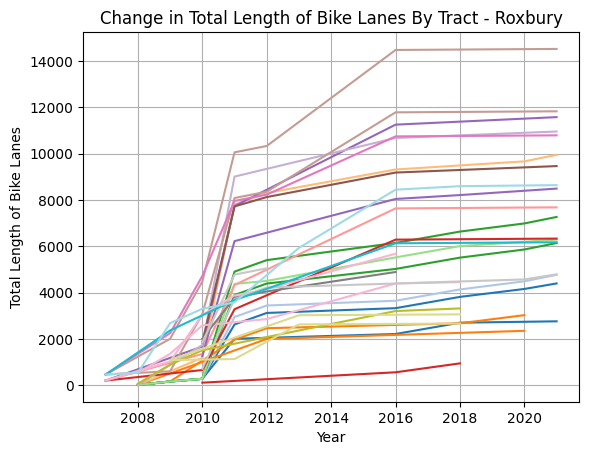

In [364]:
import matplotlib.pyplot as plt
rox_pivot['year'] = np.where(rox_pivot['year']==0, 2007,rox_pivot['year']) # replacing 0 with earliest year -1 (2007)
rox_pivot_sorted = rox_pivot.sort_values(by=['TRACTCE20', 'year']) #sorting by year to sum cummulatively

rox_pivot_sorted['cumulative_length'] = rox_pivot_sorted.groupby('TRACTCE20')['total_built'].cumsum(axis=0)

# Assuming rox_pivot contains the data with columns 'polygon_id', 'year', and total lengths of bike lanes
unique_polygon_ids = rox_pivot_sorted['TRACTCE20'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_polygon_ids)))

# Iterate through unique polygon IDs and plot a line for each polygon
for i, polygon_id in enumerate(rox_pivot_sorted['TRACTCE20'].unique()):
    polygon_data = rox_pivot_sorted[rox_pivot_sorted['TRACTCE20'] == polygon_id]
    plt.plot(polygon_data['year'], polygon_data['cumulative_length'], label=f'Polygon ID {polygon_id}', color=colors[i])

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Length of Bike Lanes')
plt.title('Change in Total Length of Bike Lanes By Tract - Roxbury')
# plt.legend(loc='best')  # Display legend for the lines
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


In [367]:
# Streets with most bike lanes
street_df = roxbury_bike.loc[roxbury_bike['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Warren Street',
 'Washington Street',
 'Seaver Street',
 'Morton Street',
 'Martin Luther King Boulevard']

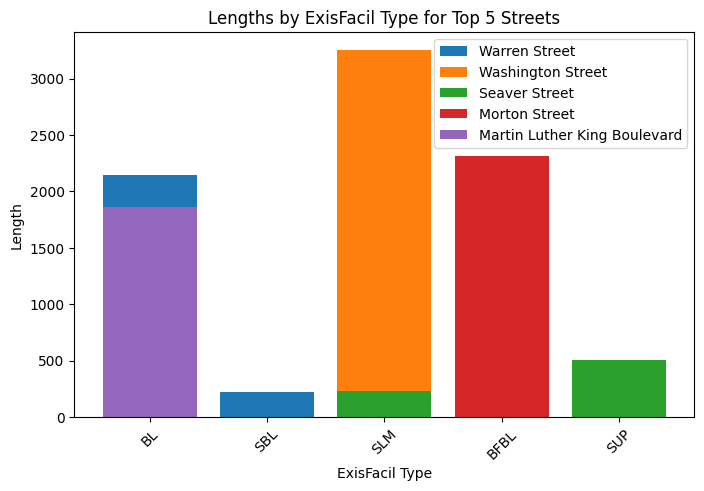

In [368]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


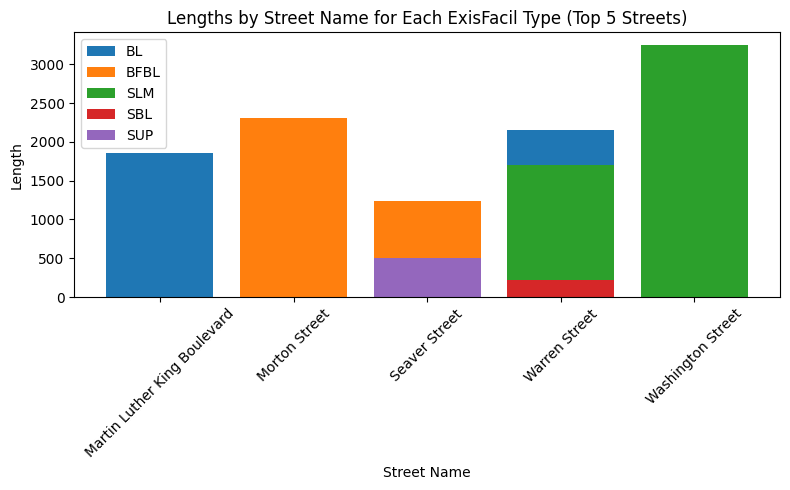

In [369]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [370]:
# # total m of lanes by year and type
# yealy_new_lanes = roxbury_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
# fig, ax = plt.subplots(figsize=(12, 6))
# yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
# ax.set_xlabel('Year')
# ax.set_ylabel('Total Length of Lanes Built (m)')
# ax.set_title('Bike Lanes by Year & Type\nDorchester')
# ax.tick_params(axis='x', rotation=45)
# plt.show()

### merge

In [29]:
all_tracts = pd.concat((rox_pivot, dorch_pivot),ignore_index=True)
all_tracts.rename(columns={'total_built':'total_built_all_lanes', 'cummulative_length': 'cummulative_length_all_lanes'}, inplace=True)
all_tracts

ExisFacil,tract,year,BFBL,BL,BLSL,SBL,SLM,SUP,total_built_all_lanes,cumulative_length,SLMTC
0,1101.03,2013,1493.940416,0.000000,0.0,0.000000,0.000000,0.0,1493.940416,1493.940416,NaN
1,1203.01,2011,0.000000,0.000000,0.0,0.000000,44.875600,0.0,44.875600,44.875600,NaN
2,708,2009,0.000000,148.433979,0.0,0.000000,0.000000,0.0,148.433979,148.433979,NaN
3,709,2011,0.000000,262.865598,0.0,0.000000,72.021193,0.0,334.886791,334.886791,NaN
4,711.01,2011,0.000000,228.244095,0.0,0.000000,0.000000,0.0,228.244095,228.244095,NaN
...,...,...,...,...,...,...,...,...,...,...,...
136,9803,2009,0.000000,202.660149,0.0,0.000000,0.000000,0.0,202.660149,721.809259,0.0
137,9803,2010,0.000000,0.000000,0.0,0.000000,128.249559,0.0,128.249559,850.058818,0.0
138,9803,2012,0.000000,0.000000,0.0,0.000000,799.222219,0.0,799.222219,1649.281036,0.0
139,9803,2020,0.000000,0.000000,0.0,1327.766788,0.000000,0.0,1327.766788,2977.047824,0.0
